In [1]:
# Import candidate models
from doubt import Boot, QuantileRegressor, QuantileRegressionForest
from sklearn.linear_model import (LinearRegression, PoissonRegressor, 
                                  GammaRegressor, HuberRegressor, 
                                  SGDRegressor)
from sklearn.ensemble import RandomForestRegressor

# Import datasets
from doubt.datasets import (Airfoil, BikeSharingDaily, BikeSharingHourly, 
                            Blog, Concrete, CPU, FacebookComments,
                            FacebookMetrics, FishBioconcentration,
                            FishToxicity, ForestFire, GasTurbine, 
                            Nanotube, NewTaipeiHousing, Parkinsons,
                            PowerPlant, Protein, Servo, SolarFlare,
                            SpaceShuttle, Stocks, Superconductivity, 
                            TehranHousing, Yacht)

# Import external libraries
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt; plt.style.use('ggplot')

# Import internal classes
from distributions import DistributionShift

In [2]:
dataset_classes = [Airfoil, Blog, Concrete, FacebookComments,
                   FacebookMetrics, FishToxicity, ForestFire, 
                   GasTurbine, Nanotube, NewTaipeiHousing, 
                   Parkinsons, PowerPlant, Protein, Servo, 
                   SolarFlare, SpaceShuttle, Stocks, 
                   Superconductivity, TehranHousing, Yacht]

In [14]:
def plot_interval_lengths(regressor, dataset, uncertainty: float = 0.05):
    # Initialise the shifter
    shifter = DistributionShift()
    
    # Load the dataset and split it
    X_train, X_test, y_train, y_test = dataset().split(test_size=0.3, random_seed=4242)
    
    # Compute the base length
    shifter.fit(X_train)
    regressor.fit(X_train, y_train)
    _, intervals = regressor.predict(X_train, uncertainty=uncertainty)
    base_length = np.mean(intervals[:, 1] - intervals[:, 0])
    
    # Initialise plot
    plt.figure(figsize=(14, 7))
    plt.title(f'Percent change in {uncertainty:.2f} uncertainty for the {dataset.__name__} dataset under feature drift')
    plt.xlabel('Number of standard deviations shifted')
    plt.ylabel('Percent change in uncertainty')

    # Compute all the other interval lengths
    xx = range(-10, 11)
    
    for col in range(X_train.shape[1]):
        interval_lengths = []
        for std in xx:
            shifter.set_params(param=std, cols=[col])
            new_X_test = shifter.transform(X_test)
            _, intervals = regressor.predict(new_X_test, uncertainty=uncertainty)
            interval_lengths.append(np.mean(intervals[:, 1] - intervals[:, 0]) / base_length - 1)

        plt.plot(xx, interval_lengths, label=f'Feature {col}')
        
    plt.legend()
    plt.savefig(f'img/{dataset.__name__}_{uncertainty:.2f}.png')
    plt.show()

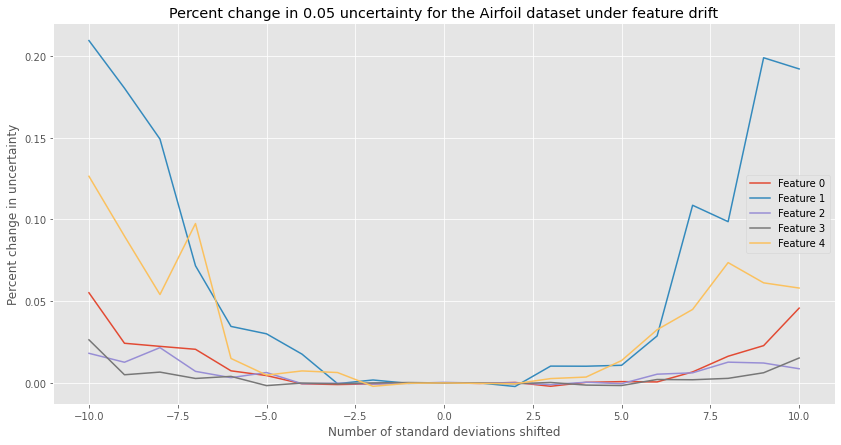

In [15]:
plot_interval_lengths(Boot(LinearRegression()), Airfoil, uncertainty=0.05)

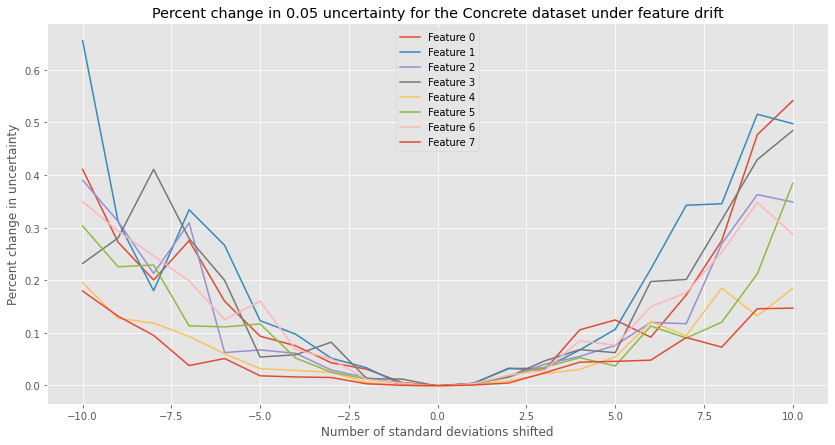

In [16]:
plot_interval_lengths(Boot(LinearRegression()), Concrete, uncertainty=0.05)

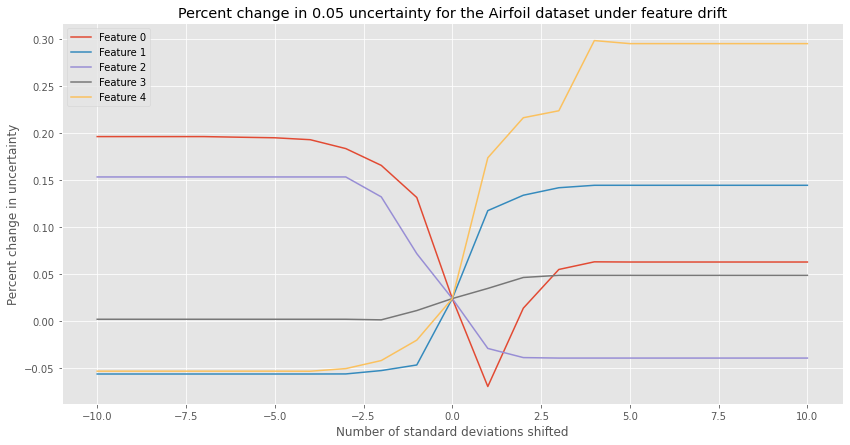

In [18]:
plot_interval_lengths(QuantileRegressionForest(min_samples_leaf=10), Airfoil, uncertainty=0.05)

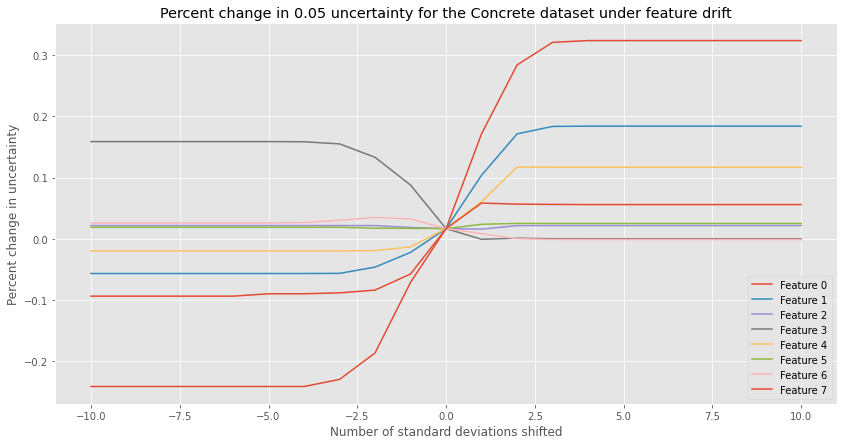

In [19]:
plot_interval_lengths(QuantileRegressionForest(min_samples_leaf=10), Concrete, uncertainty=0.05)